In [40]:
import numpy as np
import math
import json

def waveforms(N_A, N_g, N_f, t0_tf, T, B, trials, inputfile="input", phi0=0, A0=1, 
              Af=50, g0=0, gf=2, F0=90, Ff=110, N=1000):
    """
    METHOD
    ======
    Takes parameter inputs of a wave and the strength and duration of
    noise, and combines the two to form a data for each trial.
    
    PARAMETERS
    ==========
    N_A : (Int) Number of potential amplitudes
    N_g : (Int) Number of potential gammas
    N_f : (Int) Number of potential frequencies
    t0_tf : (Float) Time duration of signal
    T : (Float) Time stamp of the end time of the data. Default = None
    B : (Float) Noise amplitude of waveform
    trials : (Int) Number of different waveforms to make
    inputfile : (String) Name of json file produced containing each trial's parameters and data
    phi0 : (Float) Initial phase of the signal. Default = 0.0
    A0, Af : (Float) Amplitude lower/upper bounds
    g0, gf : (Float) Gamma lower/upper bounds
    F0, Ff : (Float) Frequency lower/upper bounds
    N : (Int) Divisions in total time series 
    
    OUTPUT
    ======
    A dictionary is created with a component for each trial, consisting
    of a list of the parameters used to create the data, and a list of
    the data. This is stored in a newly written json file.
    
    """
    
    # initalizes the arrays which span parameter space, and their lengths
    A_RANGE=np.linspace(A0,Af,N_A)
    G_RANGE=np.linspace(g0,gf,N_g)
    F_RANGE=np.linspace(F0,Ff,N_f)
    
    # number of parameters available
    A_LEN, G_LEN, F_LEN = len(A_RANGE), len(G_RANGE), len(F_RANGE)
    
    waveform_data={}
    for j in range(trials):
        waveform_data.update({j:[[],[]]})
        
        # calculates random indice for each parameter (A, f, g)
        A_RAN=np.random.randint(0,A_LEN)
        G_RAN=np.random.randint(0,G_LEN)
        F_RAN=np.random.randint(0,F_LEN)
        
        # calculates random parameters A, f, g
        A, gamma, f = A_RANGE[A_RAN], G_RANGE[G_RAN], F_RANGE[F_RAN]
        
        dt=T/N # time resolution

        #np.random.seed(seed = 1)
        NOISE = -B+2*B*np.random.random(N)  # noise!

        t0=(T-t0_tf)*np.random.random(1)[0]  # randomly generate start time
        START_INDEX=math.floor(t0/dt)        # find index associated with time

        ##NOTE: using 't0' instead of some multiple of dt may cause issues later
        
        SIG_LEN =(math.floor(t0_tf/dt)+1 if (t0_tf != T) else N) # calculate # of indexes signal takes
        INJECTED = np.zeros(N)                 # initalize injected signal, with N size array of zeroes
        for i in range(SIG_LEN):
            INJECTED[ START_INDEX + i]=t0+i*dt       # fill in injected signal with its time stamps

        w = 2 * np.pi * f
        
        # replace timestamps with their displacement values
        SR = INJECTED[START_INDEX : START_INDEX+SIG_LEN][:]
        INJECTED[START_INDEX : START_INDEX+SIG_LEN] = A*np.sin(w*SR + phi0)*np.exp(-gamma*( SR-t0))
        D_i = NOISE + INJECTED  # complete data!
        
        # gets parameters and data for each trial, stuffs it into dictionary
        parameters = [A, f, gamma, t0]
        waveform_data[j][0], waveform_data[j][1] = parameters, list(D_i)
    
    # each trial has list of parameters used and list of data values
    with open("{}-waveform_data.json".format(inputfile) , "w") as f:
        json.dump(waveform_data, f, indent=2, sort_keys=True)


In [41]:
#N_A, N_g, N_f, t0_tf, T, B, trials, filename, phi=0, A0=1, Af=50, g0=0, gf=2, F0=90, Ff=110, N=1000, filename=None
waveforms(4, 4, 4, 4, 10, 4, 10, N=250)

In [19]:
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import math
import time
import operator

class OnSource:
    
    def __init__(self, N_A, N_g, N_f, t0_tf, T, trials, inputfile="input", outputfile="output",
                 A0=1, Af=50, g0=0, gf=2, F0=90, Ff=110, N_t=1000):

        """
        METHOD
        ======
        Unpacks waveform json file to obtain each trial's parameters
        and data values. Generates a set of wave templates spanning 
        the parameter space of amplitude, frequency and gamma. 
        Creates cross-correlation/chi-squared stats with each trial's
        data and templates.
        
        PARAMETERS:
        ==========        
        N_A : (Int) Number of potential amplitudes
        N_g : (Int) Number of potential gammas
        N_f : (Int) Number of potential frequencies
        t0_tf : (Float) Time duration of signal
        T : (Float) Time stamp of the end time of the data. Default = None
        trials : (Int) Number of different waveforms to make
        inputfile : (String) Name of json file read containing each trial's parameters and data
        outputfile : (String) Name of json file written containing each trial's data parameters, data values, and base statistics values
        A0, Af : (Float) Amplitude lower/upper bounds
        g0, gf : (Float) Gamma lower/upper bounds
        F0, Ff : (Float) Frequency lower/upper bounds
        N_t : (Int) Divisions in total time series 
        
        OUTPUT
        ======
        Stores internally the base statistics, detection probability statistics, and
        false alarm probabality statistics, and can create plots of these statistics.
        
        """
        
        # initalizes the arrays which span parameter space, and their lengths
        self.A_RANGE=np.linspace(A0,Af,N_A)
        self.G_RANGE=np.linspace(g0,gf,N_g)
        self.F_RANGE=np.linspace(F0,Ff,N_f)
        
        self.A_LEN, self.G_LEN, self.F_LEN = len(self.A_RANGE), len(self.G_RANGE), len(self.F_RANGE)
                
        # constructs timestep resolution, and saves N and t0/tf internally 
        self.N, self.dt, self.t0_tf= N_t, T/N_t, t0_tf
        
        # constructs time range to pick injected signal start time from/ corresponding length 
        self.t_RANGE=np.linspace(0,T-(t0_tf),int(N_t*(1-((t0_tf)/T))))
        self.t_LEN=len(self.t_RANGE)

        # initialize arrays for various data/cross-correlations/chi-squares 
        self.noise = []
        self.cross_cor = []
        self.chi = []
        
        # constructs all templates which correspond to points in the parameter space
        self.TEMPLATES_AGF=[ self.template( A, f, g, t0_tf, self.dt) for A in self.A_RANGE 
                       for g in self.G_RANGE for f in self.F_RANGE]
        
        self.AGF_PAIR=[ [A, f, g] for A in self.A_RANGE 
                       for g in self.G_RANGE for f in self.F_RANGE]
        
        # NEW ADDITION: Reads waveform data file 
        with open("{}-waveform_data.json".format(inputfile),"r") as f: 
            waveform_data = json.load(f)
        
        self.waveform_data = waveform_data
        
        self.trials=trials
        output={}
            
        for i in range(trials):            
            
            output.update({i:[[],[],[],[]]})
            
            # isolates random a-g-f pair / data set # NEW ADDITION
            temp_AGFT, data = waveform_data[str(i)][0], waveform_data[str(i)][1]
            
            self.noise.append(data) 
            
            output[i][0], output[i][1] = temp_AGFT, data  # stores random a-g-f pair / data set 
            
            CRS_COR, CHI_SQR = [[],[]]
            
            # performs base static calculation across parameter space
            for template in self.TEMPLATES_AGF:
            
                CC_dh = list(self.CrossCorrelation(data, template, self.dt))
                CRS_COR.append(CC_dh)
                                            
                CS_dh = list(self.ChiSquare(data, template, self.dt))
                CHI_SQR.append(CS_dh)
            
            # stores base statistics to attribute
            self.cross_cor.append(CRS_COR)
            self.chi.append(CHI_SQR)
            output[i][2], output[i][3] = CRS_COR, CHI_SQR
        
        # sets output as a attribute
        self.output = output
        
        # saves 'output' as a .json in current working directory.
        '''with open("{}.json".format(outputfile), "w") as f:
            json.dump(output, f, indent=2, sort_keys=True)'''
    
    # calculates test statistic, stores it internally, and returns a copy of it as a dictionary 
    def rho(self, stat=None):
        
        # NEW ADDITION: String to equation!
        if stat == None:
            stat = "CC_IJ/(1+CS_IJ)"
            
        # counts number of tempates in parameter space
        PSPACE_LEN = len(self.AGF_PAIR)
    
        # initalizes rho statistic dictionary
        self.RHO = {}
    
        # indexed to loops through dataset trials
        for i in range(self.trials):
            rho_i = []
        
            # indexed to loops through parameter space templates and
            # calculates each rho_ij given template j
            for j in range(PSPACE_LEN):
                CC_IJ = np.array(self.cross_cor[i][j][:])
                CS_IJ = np.array(self.chi[i][j][:])
                
                # NEW ADDITION: Evaluates string (Exec gave issues... eval is the same concept though)
                p = eval(stat)
                rho_i.append(list(p))
            
            self.RHO.update({ i : rho_i })
        
        self.stat = stat
        
        return self.RHO
    
    def modulator(self, rho_ij, D): # D: foreground/background interval length
        
        rho_mod_D, RHO_ij = [] , rho_ij[:]
        
        # size of window, length of statistic values
        dn , L = math.floor(2*D/self.dt), len(RHO_ij)
        
        # NEW ADDITION: Will switch to getting min's if chi square is statistic
        if self.stat == "CS_IJ":
            
            for i in range(0,L-(L%dn),dn):
                rho_mod_D.append(min(RHO_ij[i:i+dn]))
        
            if (L-(L%dn)) != L :
                rho_mod_D.append(min(RHO_ij[L-(L%dn):L]))
        else:
            
            for i in range(0,L-(L%dn),dn):
                rho_mod_D.append(max(RHO_ij[i:i+dn]))

            if (L-(L%dn)) != L :
                rho_mod_D.append(max(RHO_ij[L-(L%dn):L]))
        
        return rho_mod_D
    
    def window(self, D):
        
        if (2*D >= self.dt):
            
            self.RHO_MOD = {}
        
            for i in range(self.trials):

                # gets the length
                TEMP_LEN = len(self.cross_cor[i])
                
                # seperates fg value from bg value
                T0_2D = math.floor(self.output[i][0][3]/(2*D))
                
                BG_VALS_IJ, FG_VAL_IJ = [], []
                for j in range(TEMP_LEN):
                
                    # calculates bg values + fg values
                    BG_VALS_IJ.append(self.modulator( self.RHO[i][j][:],D))

                    FG_VAL_IJ.append(BG_VALS_IJ[j].pop(T0_2D))
                
                self.RHO_MOD.update({ i: [ BG_VALS_IJ, FG_VAL_IJ ] })
        
            return self.RHO_MOD
        
        else: 
            print("invalid D; it is required that 2*D >= T/N")

            
# test_plotter and scatter_plotter may be combinable by using arguments to trigger the creation of specific graphs
# that is if we are always gonna be making these scatter plots

    def test_plotter(self, T, N, new_stat_only=True, index=0, output="test"):
        
        mapping = {}
        
        # Creates three dimensional array size of potential paramaters available to each data
        holder = np.full((self.F_LEN, self.A_LEN, self.G_LEN), 0, dtype=list)

        for j in range(self.F_LEN):
            for i in range(self.A_LEN):
                for k in range(self.G_LEN):
                    A=self.A_RANGE[i]
                    F=self.F_RANGE[j]
                    G=self.G_RANGE[k]
            
                    holder[(i,j,k)] = [0]
                    mapping.update({ (A,F,G) : holder[(i,j,k)]})
                    holder[(i,j,k)] = holder[(i,j,k)][0]
        
        # initalizes threshold axis points, counts for each threshold
        # and space of parameter space
        THRS_AXIS = []
        COUNT_AXIS = []
        PSPACE_LEN = len(self.AGF_PAIR)
        PSACE_PAIRS = []
        
        # NEW ADDITION: Stats per threshold
        self.Detection_Prob = []
        self.New_False_Prob = []

        # sets current threshold value
        # NEW ADDITION: thrshld will need to actually decrease in order to find smallest chi-square
        thrshlds = np.linspace(0,T,N)
        oper = operator.gt
        
        # NEW ADDITION: Threshold operations are altered accordingly
        if self.stat == "CS_IJ":
            thrshlds = np.linspace(0,T,N)[::-1]
            oper = operator.lt
            
        for thrshld in thrshlds:

            THRS_AXIS.append(thrshld)
            succ_count_thrhld = 0

            # NEW ADDITION: Detection/ False Alarm probability counters
            Detect_count = 0
            False_count = 0

            #loops from trial/ parameter space pairs 
            for i in range(self.trials):
                heat_count = 0

                for j in range(PSPACE_LEN):

                    RM_ij = np.array(self.RHO_MOD[i][0][j])
                    FG_ij = self.RHO_MOD[i][1][j]
                    N_BG_ij = len(RM_ij[RM_ij > FG_ij])
                    
                    # NEW ADDITION: Detection probability
                    if oper(FG_ij,thrshld):
                        Detect_count += 1

                    # NEW ADDITION: False Alarm probability
                    falses_ij = len(RM_ij[oper(RM_ij,thrshld)])
                    False_count += falses_ij

                    # tests if the given pair passes the threshold test
                    if ((N_BG_ij==0) and (FG_ij > thrshld)):
                        if heat_count == 0:
                            succ_count_thrhld += 1
                            mapping[tuple(self.output[i][0][:3])][0] += 1
                            heat_count += 1

            COUNT_AXIS.append(succ_count_thrhld)

            # NEW ADDITION: Detection/False Alarm probability stats
            Detect_stat = Detect_count / self.trials
            False_stat = False_count / (len(self.RHO_MOD[i][0][0]) * PSPACE_LEN * self.trials)

            # NEW ADDITION: Appending stat per threshold
            self.Detection_Prob.append(Detect_stat)
            self.New_False_Prob.append(False_stat)
        
        if new_stat_only == False:
            
            plt.plot(THRS_AXIS,COUNT_AXIS)
            plt.xlabel("$Threshold$")
            plt.ylabel("Counts")
            plt.show()
            plt.savefig("{}_counts.png".format(outputfile))

            # Don't quite get this last part of test_plotter
            w = holder.sum(index)

            cop = np.full(w.shape,0)
            z = [(i,j) for i in range(w.shape[0]) for j in range(w.shape[1])]
            for tup in z:
                cop[tup] = int(w[tup])
            
            plt.imshow(cop, cmap=plt.cm.hot) 
            plt.savefig("{}_heat.png".format(outputfile))

#             plt.imshow(heat_array, cmap=plt.cm.hot) 
    
    def Scatter_plotter(self, thrshld, xvar, yvar, outputfile="test"): 
    
        label = ["frequency", "amplitude", "gamma"]
        PSPACE_LEN = len(self.AGF_PAIR)
        SUCC_PAIRS = ([],[])
        FAIL_PAIRS = ([],[])

        #loops from trial/ parameter space pairs 
        for i in range(self.trials):
        
            succ_count_thrhld = 0  # test condition for adding to fail array

            for j in range(PSPACE_LEN):
            
                RM_ij = np.array(self.RHO_MOD[i][0][j])  # get moded rho_ij background values
                FG_ij = self.RHO_MOD[i][1][j]            # get moded rho_ij foreground value
                N_BG_ij = len(RM_ij[ RM_ij > FG_ij])     # get background vals > froeground vals
                
                # tests if the given pair passes the threshold test
                if ((N_BG_ij==0) and (FG_ij>thrshld)):
                
                    parameter_x=self.output[i][0][xvar]  # get parameter 'xvar' of trial i
                    parameter_y=self.output[i][0][yvar]  # get parameter 'yvar' of trial i
                    SUCC_PAIRS[0].append(parameter_x) # add to successes
                    SUCC_PAIRS[1].append(parameter_y)
                    succ_count_thrhld+=1
                    break
        
            # sees if trial i failed the test; adds parameters to fail array
            if succ_count_thrhld==0:
                parameter_x=self.output[i][0][xvar]
                parameter_y=self.output[i][0][yvar]
                FAIL_PAIRS[0].append(parameter_x)
                FAIL_PAIRS[1].append(parameter_y)
    
        colors = ("red", "blue")
        groups = ("pass", "fail")
        marks = ("o", "*")
        datas = (SUCC_PAIRS, FAIL_PAIRS)
    
        # Create plot
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
    
        for data, marks, color, group in zip(datas, marks, colors, groups):
            x, y = data
            ax.scatter(x, y, marker=marks, c=color, edgecolors='none', s=30, label=group)

        plt.title('found-missed plot')
        plt.xlabel(label[xvar])
        plt.ylabel(label[yvar])
        plt.legend(loc=2)
        plt.savefig("{}_scatter.png".format(outputfile))
        plt.show()
    
    def ROC_Curve(self, n_s, T, N, new_stat_only=True, outputfile="ROC_test"):
        # DON'T RUN THIS WITHOUT ADJUSTing N, IT'S HIGH TO TEST MULTIPLE RHO'S
        # base statistics are CC_IJ,CS_IJ
        # Chi Square stat isn't working
        
        # Choose soley n-rho's or an addition stat
        if new_stat_only == True:
            stat_list = []
        else:
            stat_list = ["CC_IJ"]

        # different ^n rhos are appended
        for n in range(1,n_s+1):
            rho = "CC_IJ/((1+CS_IJ)**{})".format(n)
            stat_list.append(rho)
        
        stat_length = len(stat_list)

        New_False_Probs = []
        Detection_Probs = []
        
        # First graph shows the two ROC curves ontop each other
        # Lists printed before are the False Alarm probability, and Detection Probabilities for each statistic
        for s in range(stat_length):
            self.rho(stat = stat_list[s])
            self.window(.02)
            self.test_plotter(T, N)
            #print(x.New_False_Prob)
            #print(x.Detection_Prob)
            plt.plot(self.New_False_Prob,self.Detection_Prob, label=stat_list[s])
            
        plt.xlabel("New_False_Probs")
        plt.ylabel("Detection_Probs")
        plt.title("ROC Curve: n's={}: T={}: N={}".format(n_s,T,N))
        plt.legend()
        plt.savefig("{}.png".format(outputfile))
        plt.show()

    # Produces a template given a position in parameter space
    def template(self, A, f, gamma, duration, dt):
        t = np.arange(0, duration + dt, dt)
        w = 2 * np.pi * f
        return A * np.sin(w*t)*np.exp(-gamma*t)
    
    # Produces a cross correlation function given a data input and a template in parameter space
    def CrossCorrelation(self, data, template, dt):
        ii = 0
        M = []
        
        while len(data[ii:]) >= len(template):
            M.append(np.sum((data[ii: len(template) + ii] * template)))
            ii+=1
        
        return M
         
    # Produces chi square at each "slide"
    def ChiSquare(self, data, template, dt):
        ii = 0
        C = []
        
        while len(data[ii:]) >= len(template):
            C.append(np.sum((data[ii: len(template) + ii] - template) ** 2))
            ii += 1
            
        return C

In [20]:
# N_A, N_g, N_f, t0_tf, T, trials, filename, A0=1, Af=50, g0=0, gf=2, F0=90, Ff=110, N_t=1000
x = OnSource(4, 4, 4, 4, 10, 10, N_t=250)

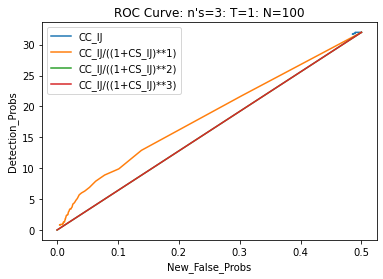

In [32]:
# n_s, T, N
x.ROC_Curve(3, 1, 100, new_stat_only=False)

In [22]:
# builds rho statistic
y=x.rho()

In [23]:
# performs modulation/ bg-fg value finding on rho
z=x.window(.02)

In [24]:
w=x.test_plotter(8,100)

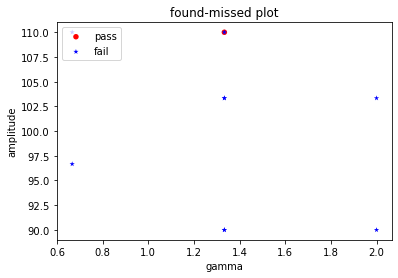

In [25]:
# scatter plot of fails & passes given threshold t
# Amplitude vs. gamma
x.Scatter_plotter( 1.5, 2, 1, outputfile="amplitude_gamma")

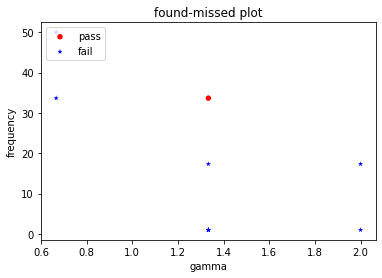

In [26]:
# scatter plot of fails & passes given threshold t
# Amplitude vs. frequency
x.Scatter_plotter( 1.5, 2, 0, outputfile="amplitude_frequency")

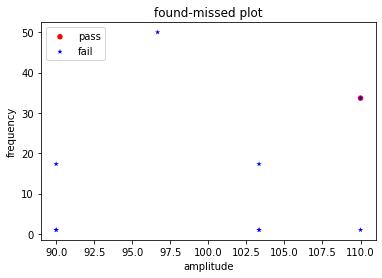

In [27]:
# scatter plot of fails & passes given threshold t
# frequency vs. gamma
x.Scatter_plotter( 1.5, 1, 0, outputfile="frequency_gamma")

Trial 0:   [frequency, amp, gamma, t0] = [50.0, 96.66666666666667, 0.6666666666666666, 0.9069362360879423]


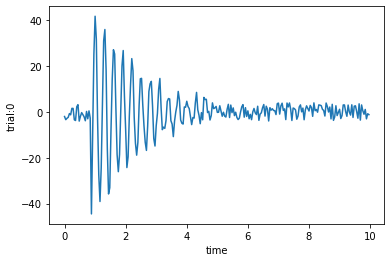

Trial 1:   [frequency, amp, gamma, t0] = [17.333333333333332, 103.33333333333333, 2.0, 5.140214979106753]


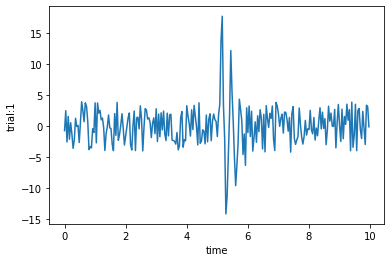

Trial 2:   [frequency, amp, gamma, t0] = [1.0, 103.33333333333333, 1.3333333333333333, 2.0218361036678845]


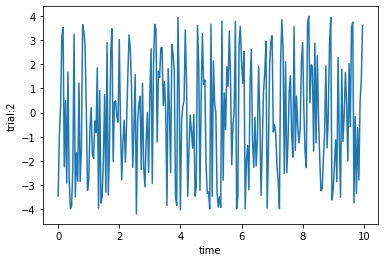

Trial 3:   [frequency, amp, gamma, t0] = [1.0, 90.0, 2.0, 0.7091557760822307]


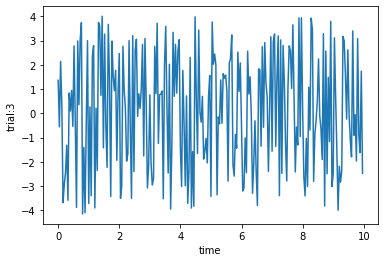

Trial 4:   [frequency, amp, gamma, t0] = [1.0, 110.0, 1.3333333333333333, 0.5502099474115458]


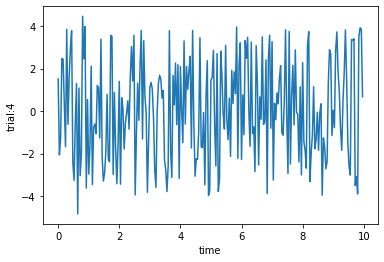

Trial 5:   [frequency, amp, gamma, t0] = [17.333333333333332, 90.0, 1.3333333333333333, 2.119454435898354]


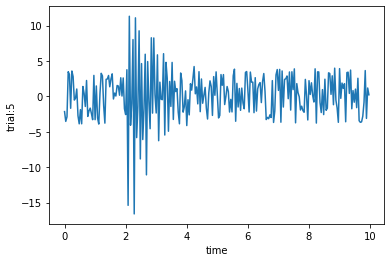

Trial 6:   [frequency, amp, gamma, t0] = [33.666666666666664, 110.0, 0.6666666666666666, 0.6801164689548382]


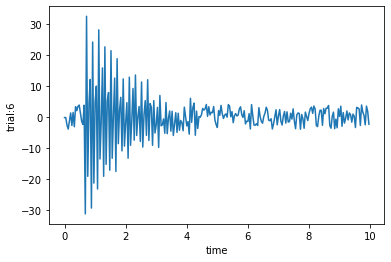

Trial 7:   [frequency, amp, gamma, t0] = [1.0, 90.0, 1.3333333333333333, 1.6095769748156181]


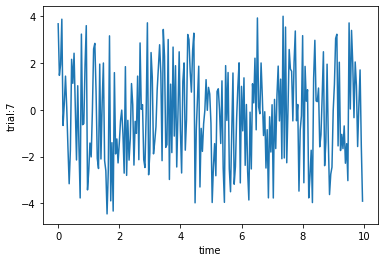

Trial 8:   [frequency, amp, gamma, t0] = [33.666666666666664, 110.0, 1.3333333333333333, 1.5365538672566492]


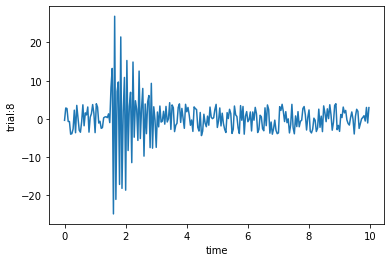

Trial 9:   [frequency, amp, gamma, t0] = [1.0, 103.33333333333333, 1.3333333333333333, 1.3452170355356179]


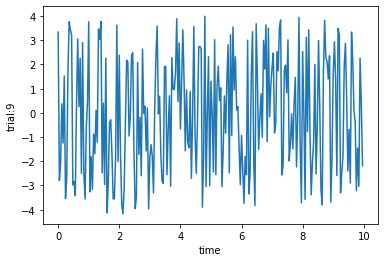

In [28]:
from matplotlib import pyplot as plt
%matplotlib inline

xaxis=[10/x.N*j for j in range(x.N)] 
for i in range(x.trials):
    print("Trial "+str(i)+":   [frequency, amp, gamma, t0] = "+str(x.output[i][0]))
    plt.plot(xaxis, x.output[i][1])
    plt.xlabel("time")
    plt.ylabel("trial:" +str(i))
    plt.show()

In [29]:
# Testing out each stats maxes arbitrarily
a = np.array(x.output[0][2][10])
b = np.array(x.output[0][3][10])
print(max(a))
print(max(b))
c = a / (1+b)
print(max(c))

# Conclusion of test of maxes of each statistics of an arbitrary template
# Theory is that thresholds must be given that are small enough to pick up rho,
# but big enough to pick up cross-correlation. Rho is really small at timestamps aside from t0. 
# As such, background peaks generally aren't able to be higher than threshold, maybe just a few.
# Onsource peaks should therefore be super large, in comparison, but seemingly not enough to
# reach threshold? 
# Clear solution would be to use a range of thresholds with a low resolution so graph is detailed.

283.472604565057
24185.86854118647
0.05044697196393306


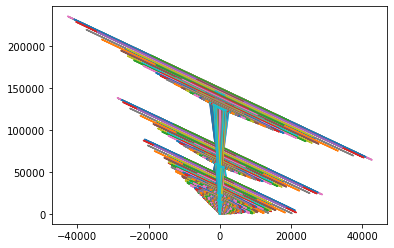

In [30]:
plt.plot(x.output[0][2], x.output[0][3])